In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, callbacks

(ds_train, ds_val), ds_info = tfds.load(
    'eurosat/rgb',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

IMG_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 30

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

ds_train = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ========== Load VGG16 Base ==========
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
base_model.trainable = False  # Freeze base initially

# ========== Build Model ==========
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(ds_info.features['label'].num_classes, activation='softmax')
])

# ========== Compile ==========
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# ========== Callbacks ==========
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)

# ========== Initial Training (Frozen base) ==========
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

# ========== Fine-tune Top VGG Layers ==========
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)

model.save("vgg16_eurosat_tfds_finetuned.h5")


2025-06-16 15:08:32.685056: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-16 15:08:33.016602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750086513.146796   31767 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750086513.192382   31767 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750086513.562547   31767 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/10


2025-06-16 15:08:56.149524: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
I0000 00:00:1750086536.426674   32283 service.cc:152] XLA service 0x7f6ecc00dbc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750086536.426735   32283 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-06-16 15:08:56.496191: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750086537.127248   32283 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/675 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.0761 - loss: 2.6645    

I0000 00:00:1750086542.527754   32283 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


673/675 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4701 - loss: 1.5160

2025-06-16 15:09:13.334722: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_194', 4 bytes spill stores, 4 bytes spill loads

2025-06-16 15:09:17.144165: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_194', 4 bytes spill stores, 4 bytes spill loads



675/675 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.4706 - loss: 1.5144 - val_accuracy: 0.7693 - val_loss: 0.7499 - learning_rate: 1.0000e-04
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7344 - loss: 0.7964 - val_accuracy: 0.8065 - val_loss: 0.6081 - learning_rate: 1.0000e-04
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7764 - loss: 0.6666 - val_accuracy: 0.8200 - val_loss: 0.5411 - learning_rate: 1.0000e-04
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.8089 - loss: 0.5844 - val_accuracy: 0.8309 - val_loss: 0.5018 - learning_rate: 1.0000e-04
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8185 - loss: 0.5460 - val_accuracy: 0.8393 - val_loss: 0.4794 - learning_rate: 1.0000e-04
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.8333 - loss: 0.5104 - val_accuracy: 0.8476 - val_loss: 0.4490 - learning_rate: 1.0000e-04
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accurac

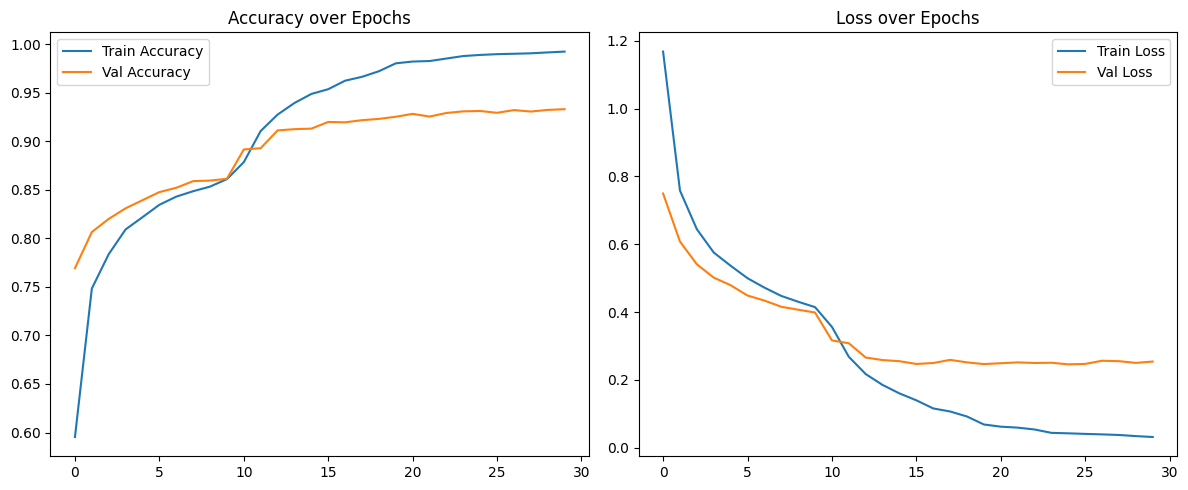

In [2]:
import matplotlib.pyplot as plt

# Combine both training phases
def plot_training(history1, history2=None):
    acc = history1.history['accuracy']
    val_acc = history1.history['val_accuracy']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']

    if history2:
        acc += history2.history['accuracy']
        val_acc += history2.history['val_accuracy']
        loss += history2.history['loss']
        val_loss += history2.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.tight_layout()
    plt.show()

# Call this after both fits
plot_training(history, fine_tune_history)


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9320 - loss: 0.2332

✅ Test Accuracy: 93.11%
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


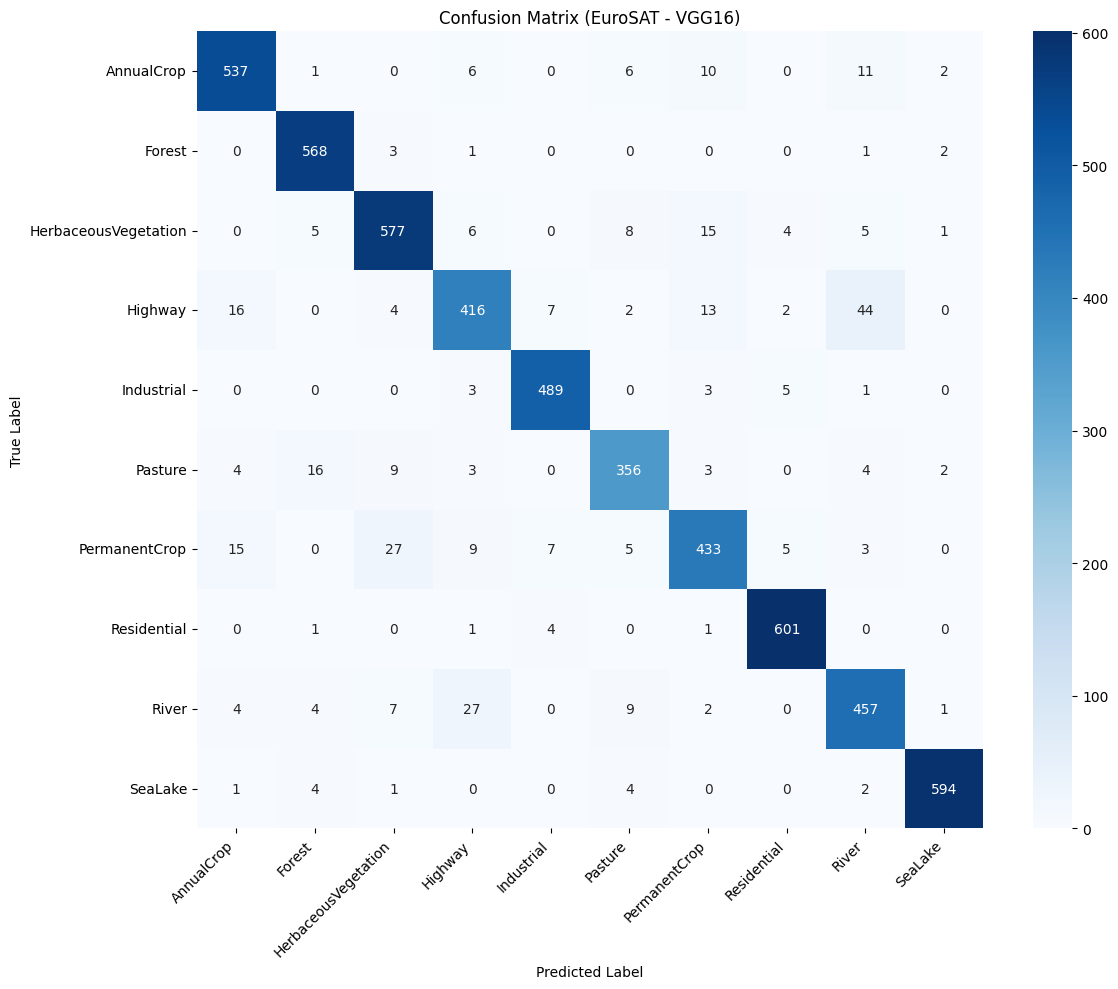

In [4]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import random

# 1. Load the test dataset (same split as ds_train/ds_val)
(ds_train_raw, ds_test_raw), ds_info = tfds.load(
    'eurosat/rgb',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# 2. Define preprocessing for test dataset (match training preprocessing)
IMG_SIZE = 64
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

ds_test = ds_test_raw.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 3. Evaluate model and print accuracy
test_loss, test_acc = model.evaluate(ds_test, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")

# 4. Predict class labels
y_pred_probs = model.predict(ds_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# 5. Extract true labels from dataset
y_true = []
for _, labels in ds_test:
    labels = tf.convert_to_tensor(labels)
    if len(labels.shape) > 1 and labels.shape[-1] > 1:
        labels = tf.argmax(labels, axis=1)
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# 6. Ensure both arrays are 1D integer class labels
y_true = y_true.astype(int)
y_pred = y_pred.astype(int)

# 7. Define class names (EuroSAT has 10 classes)
class_names = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
    'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'
]

# 8. Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 9. Plot confusion matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (EuroSAT - VGG16)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


2025-06-16 15:24:49.214816: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


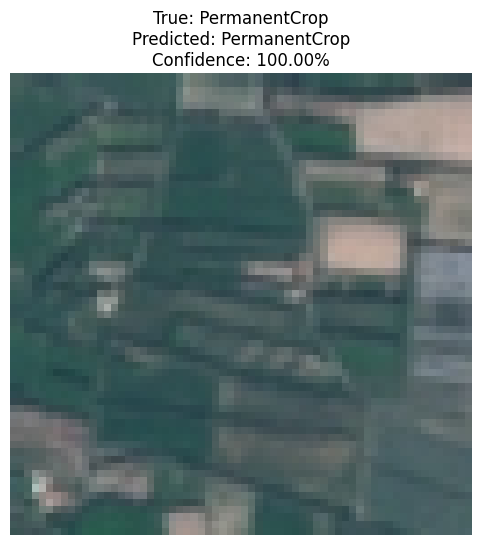


Prediction Details:
True class: PermanentCrop
Predicted class: PermanentCrop
Confidence score: 100.00%


In [5]:
# 10. Select a random image and label from the raw test set
unbatched_test = ds_test_raw.take(1000)  # Limit to 1000 samples to avoid memory issues
test_images = list(unbatched_test)
image, true_label = random.choice(test_images)

# 11. Preprocess the image for model prediction
def preprocess_for_prediction(image):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image

# 12. Prepare image for prediction (add batch dimension)
input_image = tf.expand_dims(preprocess_for_prediction(image), axis=0)

# 13. Get model prediction
pred_probs = model.predict(input_image)  # Shape: [1, 10]
pred_class = tf.argmax(pred_probs[0]).numpy()
confidence_score = tf.reduce_max(pred_probs[0]).numpy()

# 14. Display the original image with true and predicted labels
image_display = tf.cast(image, tf.uint8)  # Convert to uint8 for display
plt.figure(figsize=(6, 6))
plt.imshow(image_display)
plt.title(f"True: {class_names[true_label]}\nPredicted: {class_names[pred_class]}\nConfidence: {confidence_score:.2%}")
plt.axis('off')
plt.show()

# 15. Print prediction details
print(f"\nPrediction Details:")
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[pred_class]}")
print(f"Confidence score: {confidence_score:.2%}")
